In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 5000
import matplotlib
import nltk
#from nltk import sent_tokenize, word_tokenize, corpus
#from nltk import WordNetLemmatizer
import random
import swifter
import collections
from wordcloud import WordCloud

In [3]:
# number of prototypical words to keep.
k = 800

In [4]:
# Read data file (2019&2020)
data = pd.read_feather('../data/feather_files/data2019clean.feather')
data = pd.concat((data,\
        pd.read_feather('../data/feather_files/data2020clean.feather')))
# Take test data out
test = data.query("tclass == 'test'").reset_index(drop=True)
data = data.query("tclass == 'political' or tclass=='nonpolitical'").reset_index(drop=True)
data.head(1)

,author,created_utc,num_comments,score,domain,locked,subreddit,tclass,text
0,LazySundayBreakfast,2019-01-01,19,330,self.Liberal,False,Liberal,political,crime democrat slogan presidential election anything


In [5]:

if 1:
    #proto = pd.read_feather('../data/feather_files/proto_8.feather')
    worddict = pd.read_feather('../data/feather_files/worddict_800.feather')
    wp_proto = pd.read_feather('../data/feather_files/wp_proto_800.feather')
    wp_in_u = pd.read_feather('../data/feather_files/wp_in_u_800.feather')
    #proto2 = pd.read_feather('../data/feather_files/proto2.feather')

# Step 2

In [6]:
# get text columns for training datasets
pol = data.query("tclass == 'political'").text
nonpol = data.query("tclass == 'nonpolitical'").text

In [7]:
# Get a long strong of all text for each of the categories to analyse
long_str_p = ' '.join(pol)
long_str_np = ' '.join(nonpol)
long_str_t = ' '.join(test.text)
# Transform that string into a list of strings
tokens_p = long_str_p.split()
tokens_np = long_str_np.split()
tokens_t = long_str_t.split()

Political wordcloud


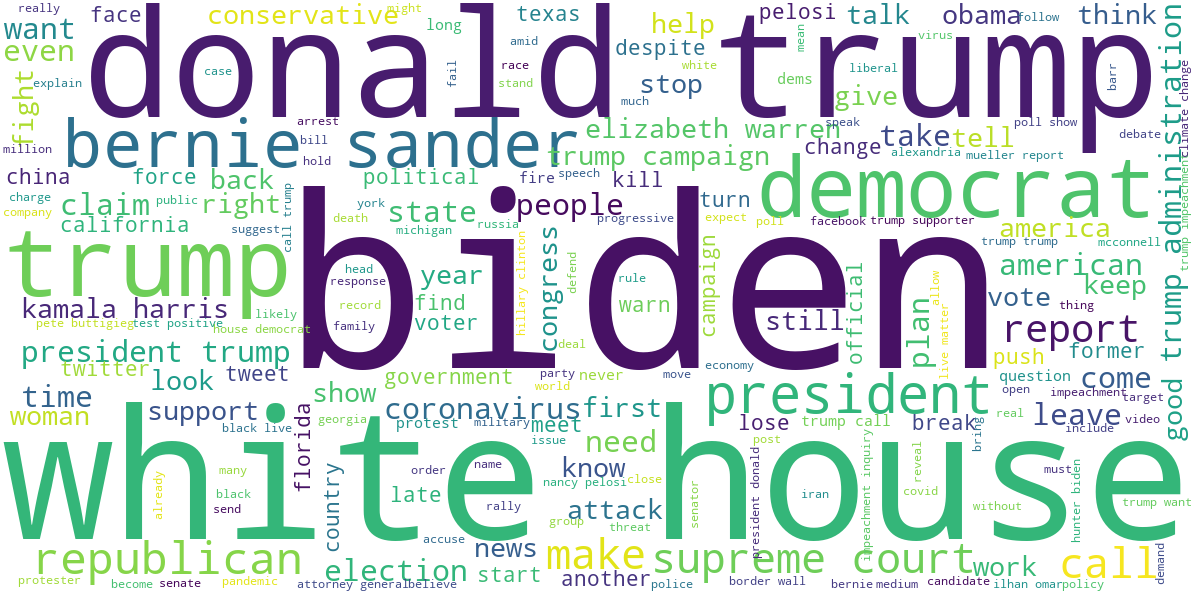

In [8]:
# Printing a WordCloud for each of them. [saving to file]
wordcloud = WordCloud(background_color="white", max_words=5000,\
                  contour_width=6, contour_color='steelblue', scale=3)
# Generate the first
print("Political wordcloud")
wordcloud.generate(long_str_p)
wordcloud.to_image()
wordcloud.to_file(f'../data/political_{k}.png')

non- Political wordcloud


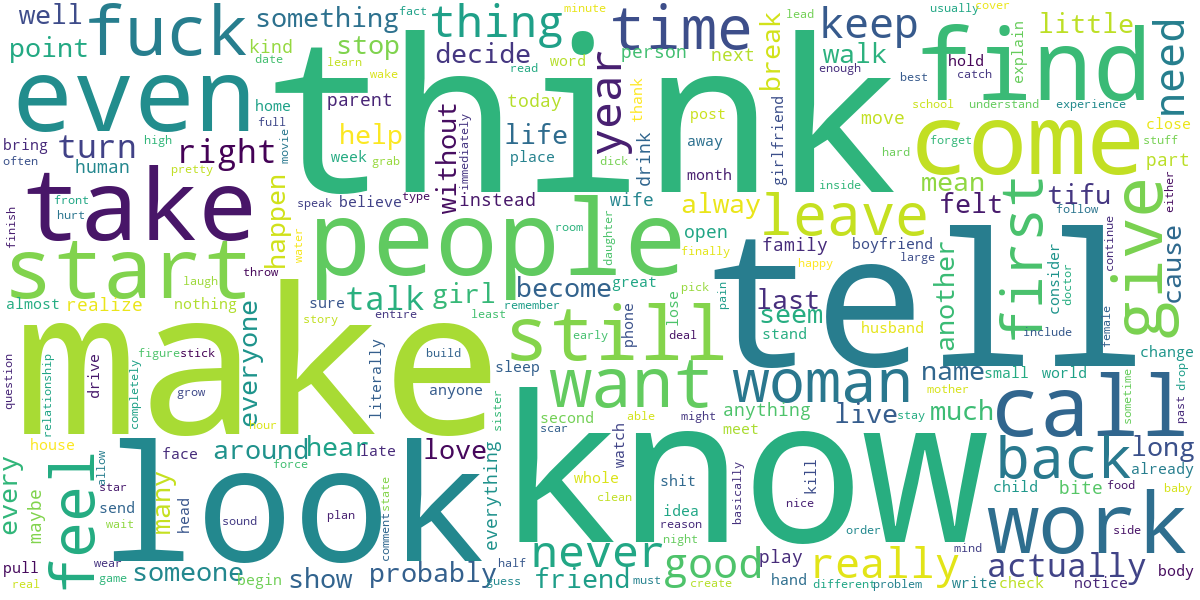

In [9]:
# Generate the second wordcloud [saving to file]
print("non- Political wordcloud")
wordcloud.generate(long_str_np)
wordcloud.to_image()
wordcloud.to_file(f'../data/nonpolitical_{k}.png')

R/Canada (test)


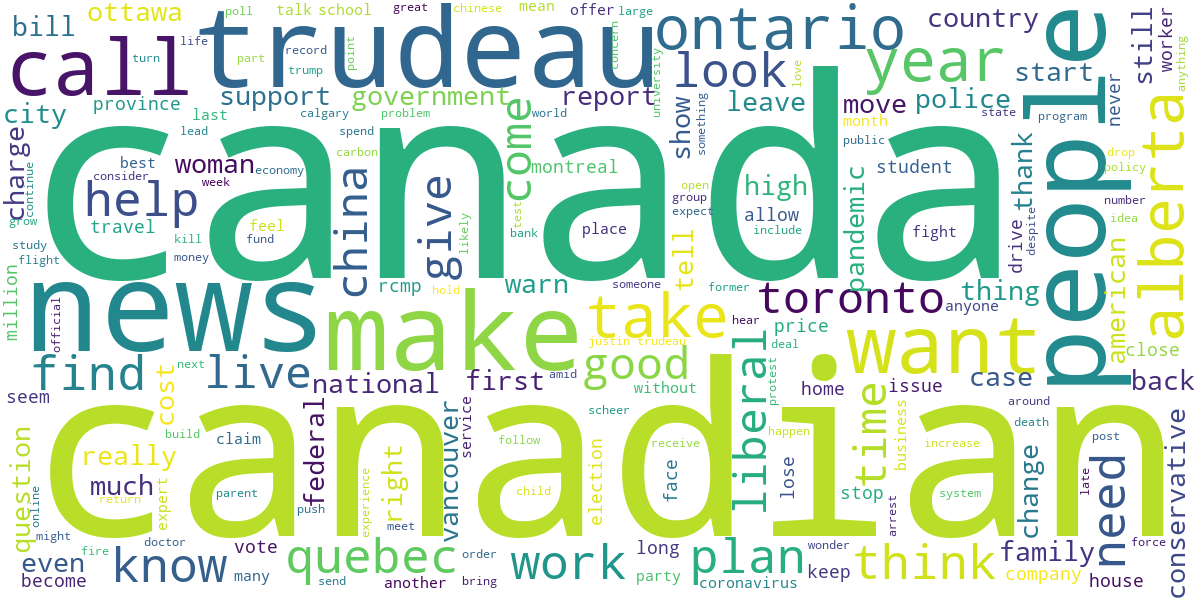

In [10]:
# Generate the third wordcloud [saving to file]
print("R/Canada (test)")
wordcloud.generate(long_str_t)
wordcloud.to_image()
wordcloud.to_file(f'../data/CA_test_{k}.png')

In [11]:
# Counting the occurences of each of the words. Output: list (word, #occurences)
print(f"Number of words are {len(tokens_p)}, {len(tokens_np)}, and {len(tokens_t)}")
counter_p = collections.Counter(tokens_p)
counter_np = collections.Counter(tokens_np)
counter_t = collections.Counter(tokens_t)
print(f"Number of distinct words is {len(counter_p)}, {len(counter_np)}, and {len(counter_t)}")

Number of words are 2527675, 3903092, and 332602
Number of distinct words is 26756, 54377, and 15191


In [12]:
# Visualizing the top 15 common words in each category [latex code available]
from prettytable import PrettyTable

table = PrettyTable()

table.title = 'Most common 15 words in each category'
table.add_column('Political', np.transpose(counter_p.most_common(15))[0])
table.add_column('Non-Political', np.transpose(counter_np.most_common(15))[0])
table.add_column('Canada', np.transpose(counter_t.most_common(15))[0])
print(table)
#table.get_latex_string()

+------------------------------------------+
|  Most common 15 words in each category   |
+-------------+---------------+------------+
|  Political  | Non-Political |   Canada   |
+-------------+---------------+------------+
|    trump    |      like     |   canada   |
|    biden    |      make     |  canadian  |
|    house    |      know     |  trudeau   |
| coronavirus |     think     |    news    |
|     call    |      tell     |   would    |
|   democrat  |     would     |    make    |
|  president  |      want     |    like    |
|    white    |      take     |    want    |
|   election  |      time     |   people   |
|     vote    |     people    | government |
|  republican |      feel     |    year    |
|    sander   |     start     |  ontario   |
|    state    |      year     |    call    |
|    donald   |      come     |  liberal   |
|   campaign  |      look     |    take    |
+-------------+---------------+------------+


Extracting first feature.
The tabl worddict would contain for each word: #occurences in each of the categories and the scores
Later, I will keep only the top 200 words in each category (only training categories are considered)

In [13]:

# Make a table of word - #occurances in class 1 - #occurances in class 2 [saving to file]
worddict = pd.DataFrame({'word':counter_p.keys(),'pol_occ': counter_p.values()})
worddict['nonpol_occ'] = worddict.word.swifter.apply(lambda x: counter_np.get(x,0))

temp = pd.DataFrame({'word':counter_np.keys(), 'nonpol_occ': counter_np.values()})
temp['pol_occ'] = temp.word.swifter.apply(lambda x: counter_p.get(x,0))
#Merge
worddict = pd.concat((worddict,temp)).drop_duplicates('word').sort_values(by='pol_occ',ascending=False)
#log
print(f"Number of distinct words is {len(worddict)}")
# Drop words occuring less than n times
n = 50
worddict = worddict.query('pol_occ >= @n or nonpol_occ >= @n').reset_index(drop=True)
print(f"# words occured at least {n} times is {len(worddict)} wordds")

# Computer score a
worddict['ssum'] = worddict.pol_occ + worddict.nonpol_occ
worddict['sc_n'] = worddict.pol_occ / worddict.ssum
worddict['sc_np'] = worddict.nonpol_occ / worddict.ssum
# Remove non-words (ie. names)
worddict = worddict[worddict.word.isin(nltk.corpus.words.words('en'))]
# Keep top k words in each class - 
#k = 400
temp = worddict.sort_values(by='sc_n', ascending=False)[0:k]
temp['class'] = 'p'
worddict = worddict.sort_values(by='sc_np', ascending=False)[0:k]
worddict['class'] = 'np'
worddict = pd.concat((temp, worddict))
worddict = worddict.drop_duplicates('word')\
.sort_values(by='sc_n', ascending=False).reset_index(drop=True)
print(f"Number of words after keeping top {k} words is {len(worddict)}")
# save to disk
worddict.to_feather(f'../data/feather_files/worddict_{k}.feather')

Pandas Apply:   0%|          | 0/26756 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/54377 [00:00<?, ?it/s]

Number of distinct words is 62097
# words occured at least 50 times is 7209 wordds
Number of words after keeping top 800 words is 1600


top political wordcloud


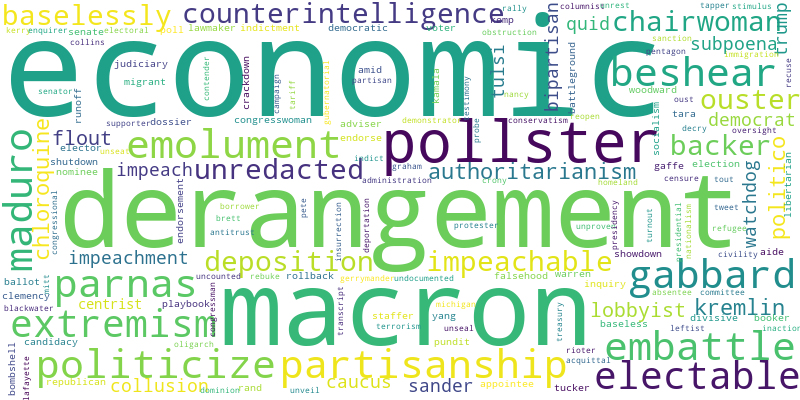

top non-political wordcloud


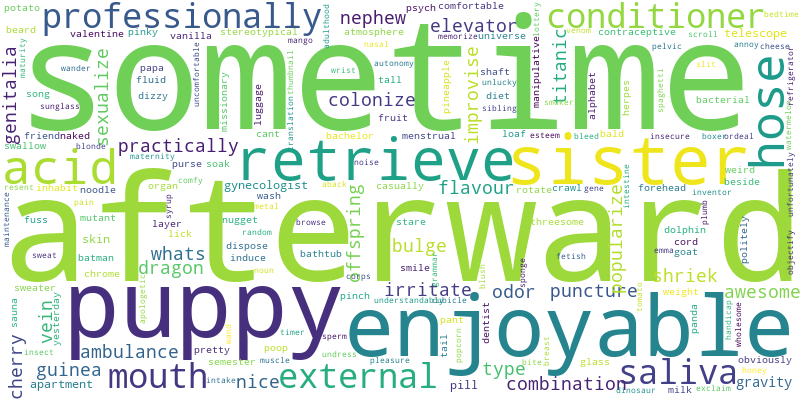

In [14]:
# Printing a WordCloud for each of them. [saving to file]
wordcloud = WordCloud(background_color="white", max_words=5000,\
                  contour_width=6, contour_color='steelblue', scale=2)
# Generate the first
print("top political wordcloud")
l_p=' '.join(worddict[worddict['class']=='p'].word)
wordcloud.generate(l_p)
wordcloud.to_image()
wordcloud.to_file(f'../data/political_top_{k}.png')
# Generate the second
print("top non-political wordcloud")
l_np=' '.join(worddict[worddict['class']=='np'].word)
wordcloud.generate(l_np)
wordcloud.to_image()
wordcloud.to_file(f'../data/nonpolitical_top_{k}.png')

In [15]:
# wp_in_u includes the frequency of the selected words in each of the posts
# the shape is list of lists. posts x words
#.allow_dask_on_strings(enable=True)\
wp_in_u=data.text.swifter\
    .apply(lambda d:( [d.count(wp) for wp in worddict.word]))
wp_in_u = pd.DataFrame(wp_in_u)
wp_in_u.to_feather(f'../data/feather_files/wp_in_u_{k}.feather')

Pandas Apply:   0%|          | 0/505676 [00:00<?, ?it/s]

--------------------
#### Proto

In [ ]:
#Transform wp_in_u into a dataframe.
# needs to loop on each post to transform individual lists.
wp_proto = pd.DataFrame(columns = worddict.word, index=data.index)
for i in np.arange(len(wp_in_u)):
        wp_proto.iloc[i] = wp_in_u.iloc[i][0]
# Detecting and fixing outliers.
# all occurances of more than 30 will be set to 30.
#outliers = pd.DataFrame(columns=['Word','Occurences>50'])
def find_outliers(tt):
    occ = ','.join([str(x) for x in np.sort(tt[tt>30])])
    if occ == '':
        return
    #wp_proto[tt.name][tt.index] = 30 # For now untill I implement the score
    return np.transpose([tt.name, occ])

outliers = wp_proto.swifter.allow_dask_on_strings(enable=True).apply(find_outliers)
outliers = outliers.values[~pd.isna(outliers.values)]
outliers = np.transpose([ t.tolist() for t in outliers.tolist()])

table = PrettyTable()
table.title = 'Words occuring more than 30 times in a single post'
table.add_column('word', outliers[0])
table.add_column('high occurences', outliers[1])
print(table)        

wp_proto.to_feather(f'../data/feather_files/wp_proto_{k}.feather')


# sum of all words in each post
sum_proto = data.text.swifter.allow_dask_on_strings(enable=True).apply(lambda d: len(d.split()))
# proto. Final feature (post x wp_word)
proto = wp_proto.divide(sum_proto,axis=0)
proto.to_feather(f'../data/feather_files/proto_{k}.feather')

Pandas Apply:   0%|          | 0/1600 [00:00<?, ?it/s]

+--------------------------------------------------------------------------------------------------+
|                        Words occuring more than 30 times in a single post                        |
+---------------+----------------------------------------------------------------------------------+
|      word     |                                 high occurences                                  |
+---------------+----------------------------------------------------------------------------------+
|  impeachment  |                             36,36,41,45,48,59,69,89                              |
|     trump     | 31,31,32,32,32,33,34,35,36,36,37,39,39,39,40,41,43,44,45,53,54,54,64,64,65,83,85 |
|    impeach    |                            36,37,41,44,45,48,59,70,89                            |
|    subpoena   |                                        35                                        |
|     sander    |                                  33,37,59,64,80                          

In [7]:
# Second score. For each class, a post gets a score
protoc = pd.DataFrame()
# The numerator
protoc['sc_p'] = proto[worddict[worddict['class']=='p'].word].sum(axis=1)
protoc['sc_np'] = proto[worddict[worddict['class']=='np'].word].sum(axis=1)
# Divide by the denomerator (same as the previous score)
protoc = protoc.divide(sum_proto,axis=0)
# save to disk
protoc.to_feather(f'../data/feather_files/protoc_{k}.feather')

In [ ]:
# number of times each proto word is mentioned once, twice, ....
# Helps to identify outliers
#freqs_proto = wp_proto.apply(lambda d: d.value_counts(), axis=0).fillna(0)

In [6]:


# sum of all words in each post
sum_proto = data.text.swifter.allow_dask_on_strings(enable=True).apply(lambda d: len(d.split()))
# proto. Final feature (post x wp_word)
proto = wp_proto.divide(sum_proto,axis=0)
proto.to_feather(f'../data/feather_files/proto_{k}.feather')

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
# freqs_proto.bidens798][freqs_proto.loc[798]!=0]

In [ ]:
# fi = freqs_proto.index[freqs_proto.index>10]

# for ind in fi:
#     freqs_proto.loc[ind][freqs_proto.loc[ind]!=0]

In [ ]:
# freqs_proto.index[freqs_proto.index>10]

In [ ]:
# lemma = WordNetLemmatizer()
# word="mueller"
# word = lemma.lemmatize(word.lower(),pos='v')
# word = lemma.lemmatize(word,pos='n')
# lemma.lemmatize(word,pos='a')